# Introduction

### Imports

In [307]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.corpus import stopwords
import time
from collections import Counter

from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

# Options for pandas
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li></ul></li></ul></li><li><span><a href="#Import-Data" data-toc-modified-id="Import-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Null-Values" data-toc-modified-id="Null-Values-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Null Values</a></span></li><li><span><a href="#Explanatory-Features-Visualizations" data-toc-modified-id="Explanatory-Features-Visualizations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Explanatory Features Visualizations</a></span></li><li><span><a href="#Target-Feature-Visualization" data-toc-modified-id="Target-Feature-Visualization-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Target Feature Visualization</a></span></li><li><span><a href="#Manufacturer-Filtering" data-toc-modified-id="Manufacturer-Filtering-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Manufacturer Filtering</a></span></li><li><span><a href="#Target-Variable-Outliers" data-toc-modified-id="Target-Variable-Outliers-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Target Variable Outliers</a></span></li><li><span><a href="#One-Hot-Encoded-Description-Words" data-toc-modified-id="One-Hot-Encoded-Description-Words-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>One-Hot Encoded Description Words</a></span></li><li><span><a href="#One-Hot-Encoded-Features" data-toc-modified-id="One-Hot-Encoded-Features-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>One-Hot Encoded Features</a></span></li><li><span><a href="#Initialize-Modeling-Dataframe" data-toc-modified-id="Initialize-Modeling-Dataframe-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Initialize Modeling Dataframe</a></span></li></ul></li><li><span><a href="#Multicollinearity" data-toc-modified-id="Multicollinearity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multicollinearity</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Evaluate-Best-Model" data-toc-modified-id="Evaluate-Best-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluate Best Model</a></span><ul class="toc-item"><li><span><a href="#Evaluating-Coefficients" data-toc-modified-id="Evaluating-Coefficients-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Evaluating Coefficients</a></span></li></ul></li><li><span><a href="#Application-and-End-User-Value" data-toc-modified-id="Application-and-End-User-Value-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Application and End User Value</a></span></li></ul></div>

# Import Data

In [308]:
with open('data/clean_data/clean_board_source_data.json') as datafile:
    data = json.load(datafile)
board_source_df = pd.DataFrame(data)

with open('data/clean_data/clean_usb_data.json') as datafile:
    data = json.load(datafile)
usb_df = pd.DataFrame(data)

In [309]:
board_source_df = board_source_df.reset_index(drop=True)
usb_df = usb_df.reset_index(drop=True)

In [310]:
df = board_source_df.append(usb_df, sort=True)

print('Original Count', len(df))

Original Count 3419


# EDA

## Null Values

There is two observations where the condition of the surfboard wasn't present on their respective surfboard ad. Being that there are only two cases, it's safe to just drop them.

In [311]:
df.isnull().sum()/df.isnull().count()*100

condition                0.058497
description_word_list    0.000000
height                   0.000000
manufacturer             0.000000
model_name               0.000000
price                    0.000000
thickness                0.000000
width                    0.000000
dtype: float64

In [312]:
df.dropna(subset=['condition'], inplace=True)

print('Current Count: ', len(df))

Current Count:  3417


## Explanatory Features Visualizations

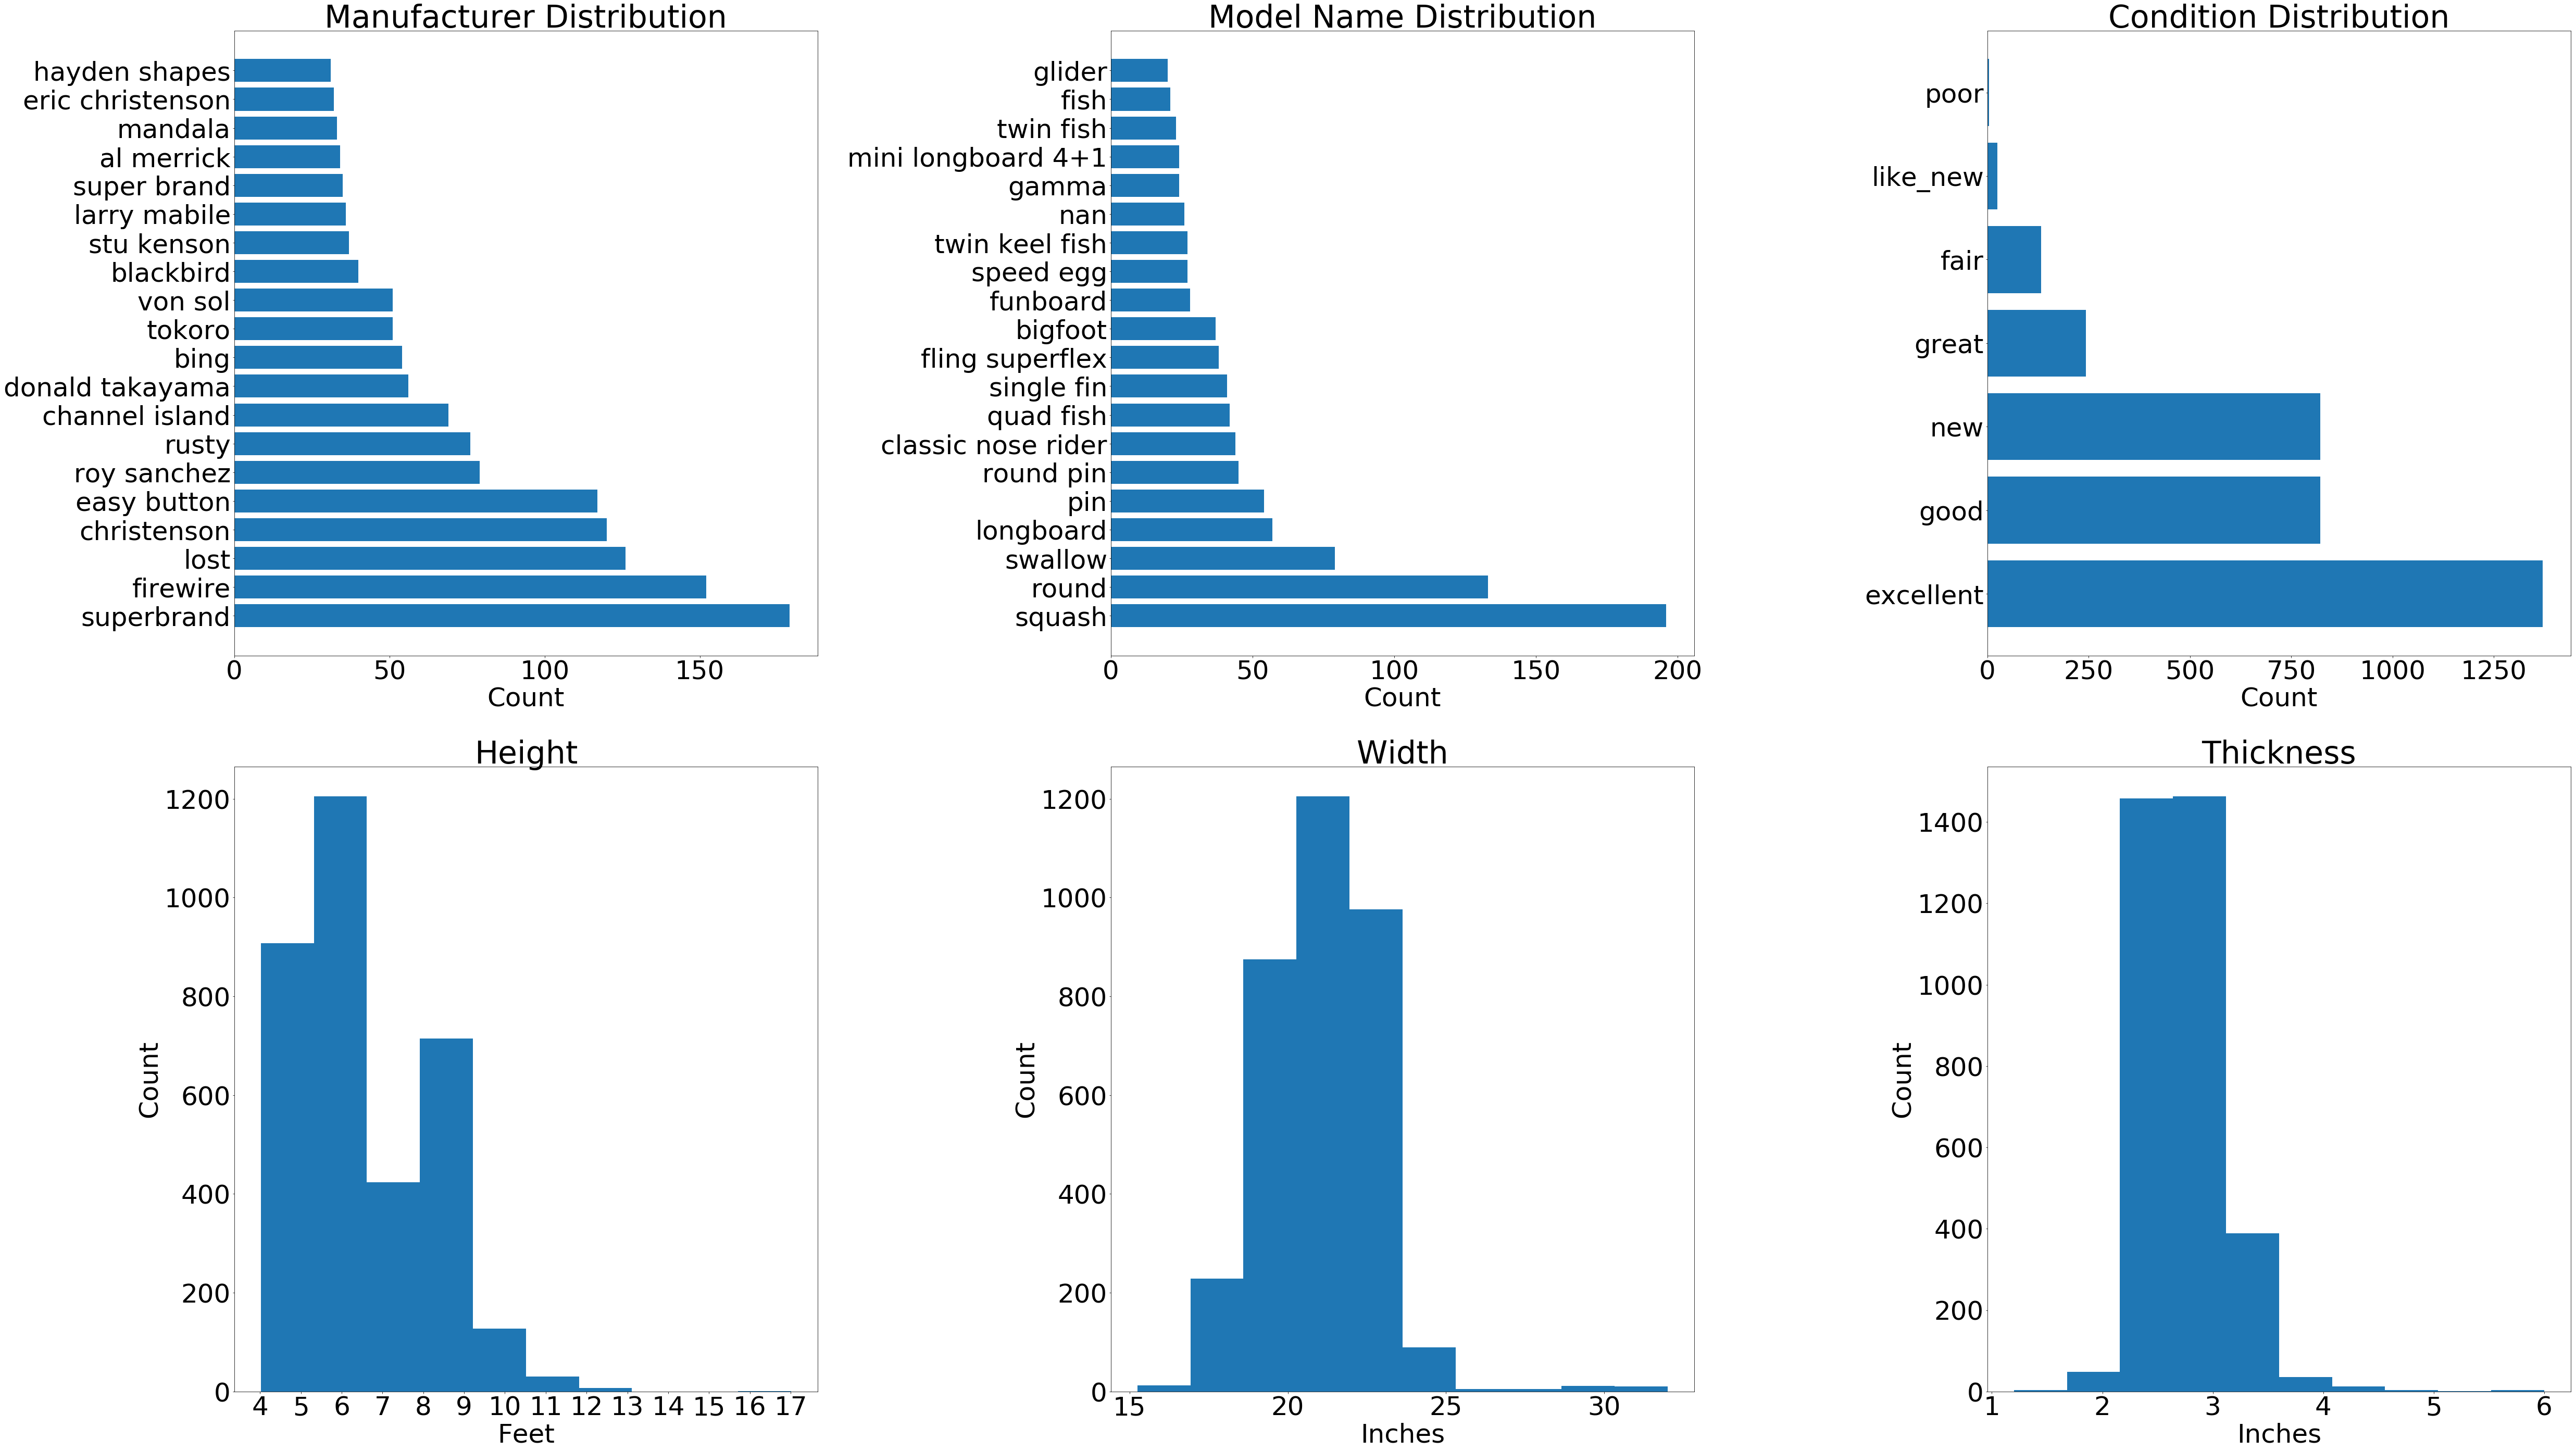

In [313]:
plt.figure(figsize=(70,40))
plt.rcParams.update({'font.size': 50})

plt.subplot(2,3,1)
plt.title('Manufacturer Distribution')
plt.xlabel('Count')
manufacturer_name = list(df['manufacturer'].value_counts().keys())[:20]
manufacturer_count = list(df['manufacturer'].value_counts().values)[:20]
plt.barh(manufacturer_name, manufacturer_count)

plt.subplot(2,3,2)
plt.title('Model Name Distribution')
plt.xlabel('Count')
model_name = list(df['model_name'].value_counts().keys())[:20]
model_count = list(df['model_name'].value_counts().values)[:20]
plt.barh(model_name, model_count)

plt.subplot(2,3,3)
plt.title('Condition Distribution')
plt.xlabel('Count')
condition_name = list(df['condition'].value_counts().keys())[:20]
condition_count = list(df['condition'].value_counts().values)[:20]
plt.barh(condition_name, condition_count)

plt.subplot(2,3,4)
plt.title('Height')
plt.xlabel('Feet')
plt.ylabel('Count')
plt.hist(df.height)
plt.xticks(np.arange(4,18,1))

plt.subplot(2,3,5)
plt.title('Width')
plt.xlabel('Inches')
plt.ylabel('Count')
plt.hist(df.width)

plt.subplot(2,3,6)
plt.title('Thickness')
plt.xlabel('Inches')
plt.ylabel('Count')
plt.hist(df.thickness)


plt.tight_layout()
plt.show()


Since there are 695 unique manufacturer and 1131 unique model names within this dataset, only the top 20 manufacturers and model names are displayed. There's five dominating manufacturers with this dataset and three dominating model names. The five dominating manufacturer have a reputation for their surfboards to hold their value. For the regression models this may cause the surfboard condition coefficients to be smaller than they should be. Essentially this may cause the model's to over fit on dominating manufacturers and not generalize well for surfboard prices that are heavily influenced by their respective condition. 

The three dominating model names are considered surfboard tail shapes. There not necessarily model names but an essential attribute of a surfboard. As you can see below, these particular model names are shared across multiple manufacturers. This will likely result in the regression models to find these general model names to be less important for predicting the surfboard's prices. Fortunately these general model names are not prevalent within top manufacturers. If this was the case then those particular model names would likely have large coefficients and cause the regression models to overestimate minority manufacturer surfboards with those particular model names.

In [314]:
#Group by top manufacturers and top model names count
top_manufacturers = ['superbrand', 'firewire', 'lost', 'christenson', 'easy button']
top_model_names = ['squash', 'round', 'swallow']

df.loc[(df['manufacturer'].isin(top_manufacturers) & df['model_name'].isin(top_model_names))].groupby(['manufacturer', 'model_name']).size()


manufacturer  model_name
christenson   squash        1
firewire      round         2
              squash        1
              swallow       1
lost          round         3
              squash        3
              swallow       2
dtype: int64

In [315]:
#Group by top model names and manufacturer count
df.loc[(df['model_name'].isin(top_model_names))].groupby(['model_name', 'manufacturer']).size()


model_name  manufacturer             
round                                     1
            aipa  akila aipa              1
            al merrick                    1
            backdoor                      2
            bret                          1
            bret  brett                   1
            brett                         2
            brice                         1
            bushman                       4
            byrne                         1
            chilli                        2
            chris gallagher               1
            cole                          1
            d pang  dennis pang  pang     2
            d tatsuno                     1
            downing                       1
            eric arakawa                  7
            fg                            1
            firewire                      2
            goin                          2
            hawk surf                     1
            hayden shapes             

The majority of surfboards are in excellent condition while a minority of surfboards are in poor to fair condition. The condition of the surfboard will likely be an important feature for predicting the respective surfboard price. As mentioned above, this may not be the case with top manufacturer surfboards.    

As of the board dimension plots, majority of the surfboards are in the shortboard size range. Any board that's longer than 8 feet, wider than 19 to 20 inches, and thicker than three inches are likely to fall under the longboard or SUP (stand-up paddleboard) category. 

Since like new and excellent are arguably the same and there is a small sample of like new surfboards, like new surfboards will be mapped to the excellent category.

In [316]:
df['condition'] = df['condition'].apply(lambda x: 'excellent' if x == 'like_new' else x)

In [317]:
df['condition'].value_counts()

excellent    1396
good          821
new           821
great         243
fair          132
poor            4
Name: condition, dtype: int64

Looking at the correlation coefficient matrix below, there's is a positive correlation between all board dimension features and price. This is especially the case with surfboard that are categorized under longboards or SUP. Longboards and SUPs are usually larger in all aspects. This results in higher material cost compared to smaller surfboards. 

In [318]:
df.corr()

,height,price,thickness,width
height,1.000000,0.477271,0.711623,0.687344
price,0.477271,1.000000,0.379799,0.402625
thickness,0.711623,0.379799,1.000000,0.806183
width,0.687344,0.402625,0.806183,1.000000


## Target Feature Visualization 

The span between the 75th percentile and the max value is substantial. Since regression model are sensitive to outliers, the outliers will be winsorized at a specific threshold specified in the outlier section. 

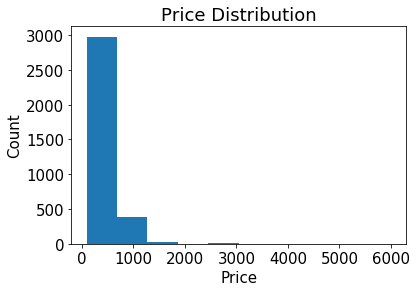

In [319]:
plt.rcParams.update({'font.size': 15})

plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.hist(df['price'])
plt.show()

In [320]:
df['price'].describe()

count    3417.000000
mean      497.614033
std       291.967302
min        89.000000
25%       350.000000
50%       450.000000
75%       575.000000
max      6000.000000
Name: price, dtype: float64

## Manufacturer Filtering

While interpreting the model's coefficients, I've found that the one-hot encoded manufacturers features were important features for determining price. Less frequent manufacturers surfboards had larger residuals compared to more frequent manufacturer surfboards. To reduce the loss for each model, the cell below filters out manufacturer with surfboard counts below a defined threshold. 

In [321]:
print('Previous Count: ', len(df))

threshold = 10
keep_manufacturer_list = []

for manufacturer, count in df.groupby('manufacturer').size().items():
    if count >= threshold:
        keep_manufacturer_list.append(manufacturer)

df = df[df['manufacturer'].isin(keep_manufacturer_list)]

print('Current Count: ', len(df))

Previous Count:  3417
Current Count:  2158


## Target Variable Outliers

In [322]:
outlier_cols = ['price']
for col in outlier_cols:
    #define 25th percentile and 75th percentile
    q25, q75 = np.percentile(df[col], [25,75])
    #define interquartile range
    iqr = q75 - q25
    #outlier threshold
    min_val = q25 - iqr
    max_val = q75 + iqr

    #Outlier count
    min_outliers, max_outliers = len(np.where(df[col] < min_val)[0]), len(np.where(df[col] > max_val)[0])
    #outlier pct portional to len of df
    min_pct, max_pct = min_outliers/len(df), max_outliers/len(df)
    #Original Max Outlier
    max_val = df[col].max()
    #create new winsorized price column
    df['winsorized_'+col] = winsorize(df[col], (min_pct, max_pct))
    #Upper bound threshold value
    max_cap_val = df['winsorized_'+col].max()
    
    
    print()
    print('Winsorized Column: ', col)
    print()
    print('Lower Bound Outliers Count: ', min_outliers)
    print('Upper Bound Outliers Count: ', max_outliers)
    print('Max Outlier Value: ', max_val)
    print('Upper Bound Outlier Capped Value: ', max_cap_val)


Winsorized Column:  price

Lower Bound Outliers Count:  22
Upper Bound Outliers Count:  188
Max Outlier Value:  4800.0
Upper Bound Outlier Capped Value:  795.0


In [323]:
df['winsorized_price'].describe()

count    2158.000000
mean      495.278244
std       157.084163
min       199.000000
25%       395.000000
50%       477.500000
75%       595.000000
max       795.000000
Name: winsorized_price, dtype: float64

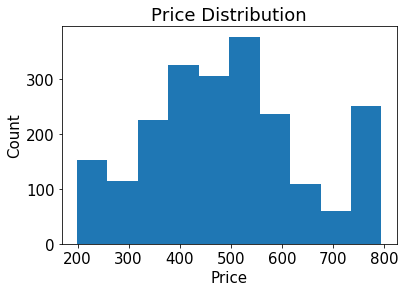

In [324]:
plt.rcParams.update({'font.size': 15})

plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.hist(df['winsorized_price'])
plt.show()

## One-Hot Encoded Description Words

One-Hot Encode surfboard terms within the description feature that are strongly correlated with surfboard price. 

Negatively Correlated Terms:
    - Ding/Dent: Dent in surfboard usually causing the surfboard's outer shell (fiberglass) to crack. 
    - Pressure Ding/Dent: Less severe form of a regular surfboard ding without cracking the fiberglass
    - Professionally fixed ding: Ding repair is sanded flush with board (won't cause board to drag), water tight,  and no air bubbles
    
Positive Correlated Terms:
    - SUP (Stand up Paddle Board)
    - Longboard (surfboard height >= ~ 8')
    - Hydro foil (Google it)
    - No dings (no dents)
    - Epoxy (Type of material used with surfboard) 

In [325]:
#used to create ngrams of description word list
def ngram(text, n_gram):
    n_gram_list = []
    for i in range(len(text)-n_gram):
        text_seq = ' '.join(text[i:i+n_gram])
        n_gram_list.append(text_seq)
    unique_ngram_list = list(np.unique(n_gram_list))
    return unique_ngram_list

In [326]:
trigram_list = ['professionally fixed dings', 'professionally fixed ding', 'professionally repaired dings',
                'light pressure dents', 'minor pressure denting', 'minimal pressure dents', 
                'minimal pressure denting','various pressure dents']

bigram_list = ['repaired dings', 'repaired ding', 'pressure dents', 'pressure dent', 
               'nose ding', 'rail ding', 'cracked fin', 'no dings', 'deck patch']

unigram_list = ['sup', 'longboard', 'hydrofoil', 'epoxy', 'shortboard', 'fish', 'gun', 'semi-gun', 'funboard']

In [327]:
#create tri/bigram columns for matching one hot encoded words in description

df['trigram_description_list'] = df['description_word_list'].apply(lambda x: ngram(x, 3))
df['bigram_description_list'] = df['description_word_list'].apply(lambda x: ngram(x, 2))

In [328]:

df.reset_index(drop=True, inplace=True)

#init df for one-hot encoded description words
description_one_hot_df = pd.DataFrame(index=range(len(df)))

def create_one_hot_columns(gram_list, column_gram_list):
    for gram in gram_list:
        #init one-hot columns
        underscore_gram = gram.replace(' ', '_')
        description_one_hot_df['DV_'+underscore_gram] = 0

    for i,word_list in enumerate(df[column_gram_list]):
        for gram in gram_list:
            if gram in word_list:
                underscore_gram = gram.replace(' ', '_')
                description_one_hot_df.at[i, 'DV_'+underscore_gram] = 1

In [329]:
#make nicer

create_one_hot_columns(unigram_list, 'description_word_list')
create_one_hot_columns(bigram_list, 'bigram_description_list')
create_one_hot_columns(trigram_list, 'trigram_description_list')

## One-Hot Encoded Features

In [330]:
# one-hot columns with single categorical value
one_hot_df = pd.get_dummies(df[['condition', 'manufacturer', 'model_name']]).reset_index(drop=True)

## Initialize Modeling Dataframe

In [331]:
# #combined terms

# #columns with continous values
# df['combined_board_dimensions'] = df['height'] + df['width'] + df['thickness']
# continous_df = df[['combined_board_dimensions', 'winsorized_price']].copy()

# #columns with one-hot description words
# description_one_hot_df.reset_index(drop=True, inplace=True)

# # one-hot columns with single categorical value
# df['manufacturer_model_name'] = df['manufacturer'] + '_' + df['model_name']
# one_hot_df = pd.get_dummies(df[['condition', 'manufacturer_model_name']]).reset_index(drop=True)

# #create dataframe with features that will be used for modeling

# model_df = continous_df.join(one_hot_df).join(description_one_hot_df)

# data_x = model_df[model_df.columns[~model_df.columns.isin(['winsorized_price'])]]
# data_y = model_df['winsorized_price']

In [332]:
#columns with continous values
continous_df = df[['height', 'width', 'thickness', 'winsorized_price']].copy()

#columns with one-hot description words
description_one_hot_df.reset_index(drop=True, inplace=True)


#create dataframe with features that will be used for modeling

model_df = continous_df.join(one_hot_df).join(description_one_hot_df)

data_x = model_df[model_df.columns[~model_df.columns.isin(['winsorized_price'])]]
data_y = model_df['winsorized_price']

# Multicollinearity

Multicollinearity between manufacturer and model name and between board dimensions. Combined manufacturer and model and board dimensions separately with intention to eliminate multicollinearity but effort resulted in lower performance than with multicollinearity.  

In [333]:
# x_corr_df = data_x.corr()

# multicollinearity_count = 0
# for corr_col in x_corr_df.columns:
#     for i,corr in enumerate(x_corr_df[corr_col]):
#         if corr > .7 and corr != 1:
#             multicollinearity_count += 1
#             print('High Multicollinearity between {} and {}'.format(x_corr_df[corr_col].index[i], corr_col))
# print('Multicollinearity Count: ', multicollinearity_count)

# Modeling

In [335]:
# Optimize hyperparameters for each model and add metrics results to model results dataframe

def model_results(model_list, train_x, train_y, test_x, test_y):
    
    model_dict = []
    for name, model in model_list.items():
        print(name)
        model_stats = {}
        if name != 'linear':        
            model = GridSearchCV(model, model.parameters, cv=3)
        
        model.fit(train_x, train_y)
            
        if name in ['elastic', 'lasso', 'ridge']:
            model_stats['best_alpha'] = model.best_params_['alpha']
            model_stats['coef'] = model.best_estimator_.coef_
        
        pred_y = model.predict(test_x)
        
        model_stats['r2'] = model.score(test_x, test_y)
        model_stats['root_MSE'] = np.sqrt(mse(test_y, pred_y))
        model_stats['MAE'] = np.abs(test_y - pred_y).mean()
        model_stats['MAPE'] = (np.abs(test_y - pred_y) / test_y).mean() * 100
        model_stats['model_name'] = name
        
        
        model_dict.append(model_stats)
            
    model_results_df = pd.DataFrame(model_dict).set_index('model_name')

    return model_results_df

In [336]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=.2)

#hyper parameter testing attributes

alpha_dict = {'alpha': [.01,.1,1,10]}

elastic = ElasticNet()
elastic.parameters = alpha_dict

lasso = Lasso()
lasso.parameters = alpha_dict

ridge = Ridge()
ridge.parameters = alpha_dict

linear = LinearRegression()

mlp = MLPRegressor()
mlp.parameters = {'solver': ['lbfgs', 'adam'],
                  'alpha': [.001,.01,.1,1]}

model_list = {'elastic': elastic, 'ridge': ridge, 'lasso': lasso, 'linear': linear, 'mlp': mlp}


In [337]:
model_results_df = model_results(model_list, train_x, train_y, test_x, test_y)

model_results_df

elastic
ridge
lasso


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


linear
mlp


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached an

,MAE,MAPE,best_alpha,coef,r2,root_MSE
model_name,,,,,,
elastic,5.826870e+01,1.340238e+01,0.01,"[37.881718876610655, 16.952909078764296, 9.896...",7.641926e-01,7.512884e+01
ridge,5.889168e+01,1.367371e+01,1.00,"[34.5157611069253, 11.940753322309643, 28.3860...",7.524493e-01,7.697684e+01
lasso,5.905143e+01,1.355867e+01,0.10,"[36.178088077811225, 15.27461932828557, 16.019...",7.591233e-01,7.593209e+01
linear,2.905191e+11,5.710422e+10,NaN,NaN,-9.452781e+19,1.504208e+12
mlp,5.890634e+01,1.358762e+01,NaN,NaN,7.584444e-01,7.603902e+01


Evaluate each model's results

# Evaluate Best Model

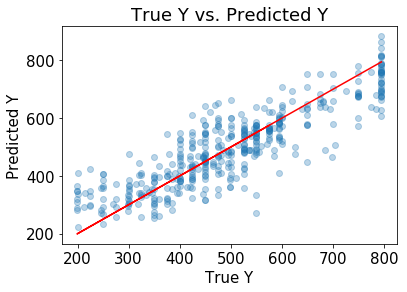

In [342]:
ridge = Ridge(alpha=1)
ridge.fit(train_x, train_y)
pred_y = ridge.predict(test_x)

plt.scatter(test_y, pred_y, alpha=.3)
plt.plot(test_y, test_y, color='red')
plt.title('True Y vs. Predicted Y')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

Evaluate the amount of error accesible in real world application/ use case and manufacturer threshold

In [340]:
error_term = pred_y - test_y

plt.scatter(pred_y, error_term)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

bart_stats = bartlett(pred_y, error_term)
lev_stats = levene(pred_y, error_term)

print("Bartlett t-test: {0:3g} ... P-value: {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene t-test: {0:3g} ... P-value: {1:.3g}".format(lev_stats[0], lev_stats[1]))

Not evenly distributed

OVershoot undershoot

## Evaluating Coefficients 

Describe coeff

In [392]:
coef_dict = dict(zip(data_x.columns, ridge.coef_))

sorted_coef_dict = sorted(coef_dict.items(), key=lambda kv: kv[1])

In [398]:
strongest_coef = dict(sorted_coef_dict[:10])
strongest_coef = strongest_coef.update(dict(sorted_coef_dict[-10:]))

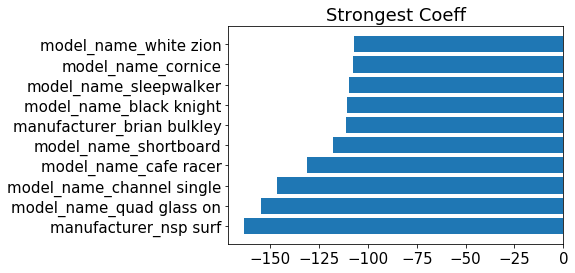

In [399]:
plt.title('Strongest Coeff')
plt.barh(list(strongest_coef.keys()), list(strongest_coef.values()))

plt.show()

# Application and End User Value

Application:

Models would be trained only with data from one surf shop since surf shops will have different opinions on prices. The model can be a feature on the respective surf shop website. Users can enter their surfboard information and use the predicted surfboard price to determine if they want to sell their surfboard at that specific surf shop or use it as a reference price for selling their board at other surf shops. 

User Experience:

User access predictive surfboard price via surf shop's website/app:

User input (drop-down list):
- Board Dimensions (height, width, thickness)
- Condition (poor, fair, good, excellent, new)
- Manufacturer
- Model Name
- Type of board (shortboard, longboard, SUP)
- How many fixed dings are there? 
    - For each ding select size of ding:
        - Small (<= 1 square inches)
        - Medium (<= 6 square inches)
        - Large (=> 6 square inches)
- How many unfixed dings are there?

Product Output: Predicted Surfboard Price (continous value)
